In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

In [2]:
emb_dim=100

# Terms

* variable
* function
* predicate
* clause

In [3]:
class Predicate:
    def __init__(self, name, variables, negation):
        self.name=name
        self.variables=variables
        self.negation=negation
    
    def show(self):
        s=''
        if self.negation:
            s+='¬'
        s='%s%s(%s)'%(s,self.name,', '.join(self.variables))
        return s

In [4]:
class Clause:
    def __init__(self, v,w,predicates):
        self.v=float(v)
        self.w=float(w)
        self.predicates=predicates
    def show(self):
        ss=[]
        for p in self.predicates:
            ss.append(p.show())
        ss=' ∨ '.join(ss)
        return ss

In [5]:
class KnowledgeBase:
    def __init__(self,clauses):
        self.clauses=clauses
    def show(self):
        for i,c in enumerate(self.clauses):
            print(c.show())
    def union(self, knowledge_base):
        new_knowledge_base=copy.deepcopy(knowledge_base)
        for clause in self.clauses:
            new_knowledge_base.clauses.append(clause)
        return new_knowledge_base

In [6]:
class Propositional:
    def __init__(self, v, w, conditions, clause):
        self.v = v
        self.w = w
        self.conditions = conditions
        self.clause = clause

    def generate_knowledge_base(self,constants):
        self.knowledge_base = KnowledgeBase([self.clause])
        for condition in self.conditions:
            new_knowledge_base = self.bound_knowledge_base(
                self.knowledge_base, condition[1], constants, condition[0])
            self.knowledge_base = new_knowledge_base
        return self.knowledge_base

    def bound_knowledge_base(self, knowledge_base, variable, constants,
                             existential):
        clauses = []
        for clause in knowledge_base.clauses:
            clauses += self.bound_clause_variable_with_constants(
                clause, variable, constants, existential)
        return KnowledgeBase(clauses=clauses)

    def bound_clause_variable_with_constants(self, clause, variable, constants,
                                             existential):
        clauses = []
        for constant in constants:
            clauses.append(
                self.bound_clause_variable_with_constant(
                    clause, variable, constant))
        if existential:
            all_predicates = []
            for clause in clauses:
                all_predicates += clause.predicates
            return [Clause(clauses[0].v, clauses[0].w, all_predicates)]
        else:
            return clauses

    def bound_clause_variable_with_constant(self, clause, variable, constant):
        new_clause = copy.deepcopy(clause)
        for i in range(len(clause.predicates)):
            for j in range(len(new_clause.predicates[i].variables)):
                if new_clause.predicates[i].variables[j] == variable:
                    new_clause.predicates[i].variables[j] = constant
        return new_clause

In [7]:
def load_knowledge_base(filename):
    clauses=[]
    for line in open(filename):
        line=line.strip().split('|')
        v,w=line[0].split(',')
        line=line[1].strip().split(',')
        if line[0]=='not':
            negation=True
            line=line[1:]
        else:
            negation=False
        predicate=Predicate(name=line[0],negation=negation,variables=line[1:])
        clauses.append(Clause(v=v,w=w,predicates=[predicate]))
    return KnowledgeBase(clauses)

In [8]:
def load_propositional(filename):
    propositionals=[]
    for line in open(filename):
        line=line.strip().split('|')
        condition=[]
        v,w=line[0].split(',')
        for c in line[1].strip().split(','):
            c=c.strip().split(' ')
            if c[0]=='all':
                c[0]=False
            else:
                c[0]=True
            condition.append(c)
        predicates=[]
        for predicate in line[2:]:
            predicate=predicate.strip().split(',')
            if predicate[0]=='not':
                predicate=Predicate(name=predicate[1],negation=True,variables=predicate[2:])
            else:
                predicate=Predicate(name=predicate[0],negation=False,variables=predicate[1:])
            predicates.append(predicate)
        propositionals.append(Propositional(v,w,condition,Clause(v,w,predicates)))
    return propositionals

In [9]:
def show_results(model, knowledge_base):
    wrong=0
    for clause in knowledge_base.clauses:
        output=model.forward(clause=clause)
        if output[0].data.numpy()[0]<0.01:
            continue
        print(clause.show())
        print(output[0].data.numpy()[0], output[1].data.numpy()[0])
        wrong+=1
    print(wrong)

In [10]:
class GConstants(nn.Module):
    def __init__(self, constants,emb_dim):
        super(GConstants, self).__init__()
        self.symbol2id=dict()
        self.id2symbol=dict()
        for i,s in enumerate(constants):
            self.symbol2id[s]=i
            self.id2symbol[i]=s
        self.embeddings = nn.Embedding(len(self.symbol2id), emb_dim)
    def forward(self,constants):
        constant_id=[]
        for c in constants:
            constant_id.append(self.symbol2id[c])
        embs=self.embeddings(Variable(torch.LongTensor(constant_id)))
        embs=torch.cat(embs).view(1,-1)
        return embs

In [11]:
class GPredicate(nn.Module):
    def __init__(self, name, variable_count, emb_dim):
        super(GPredicate, self).__init__()
        self.name=name
        self.variable_count=variable_count
        self.emb_dim=emb_dim
        m=variable_count*emb_dim
        self.variable_count=variable_count
        self.W=Variable(torch.randn(m, emb_dim, m), requires_grad=True)
        self.V=Variable(torch.randn(m, emb_dim), requires_grad=True)
        self.B=Variable(torch.randn(emb_dim), requires_grad=True)
        self.u=Variable(torch.randn(emb_dim), requires_grad=True)
    def forward(self, embs, negation):
        m=self.variable_count*self.emb_dim
        W=self.W.view(m,-1)
        output=torch.mm(embs,W)
        output=output.view(-1,m)
        output=torch.mm(output,embs.view(-1,1))
        output=output.view(1,-1)
        output=output.add(torch.mm(embs,self.V))
        output=output.add(self.B)
        output=output.view(-1)
        output=torch.tanh(output)
        output=torch.mul(output,self.u).sum()
        output=torch.sigmoid(output)
        if negation:
            output=1.0-output
        return output

In [12]:
class LTN(nn.Module):
    def __init__(self, emb_dim, constants, predicates):
        super(LTN, self).__init__()
        self.emb_dim=emb_dim
        self.Constants=GConstants(constants, emb_dim)
        self.Predicates=dict()
        for name,n in predicates:
            self.Predicates[name]=GPredicate(name,n,emb_dim)
    def forward(self, clause):
        Phi=None
        v=Variable(torch.FloatTensor([clause.v]))
        w=Variable(torch.FloatTensor([clause.w]))
        for predicate in clause.predicates:
            negation=predicate.negation
            name=predicate.name
            constants=predicate.variables
            embs=self.Constants.forward(constants)
            output=self.Predicates[name].forward(embs,negation)
            if Phi is None or Phi.data.numpy()[0]<output.data.numpy()[0]:
                Phi=output
        if (Phi>w).data.all():
            loss=Phi-w
        elif (Phi<v).data.all():
            loss=v-Phi
        else:
            loss=Variable(torch.FloatTensor([0]),requires_grad=True)
        return loss,Phi
    def parameters(self):
        results=list(self.Constants.parameters())
        for name in self.Predicates:
            results+=list(self.Predicates[name].parameters())
        return results

In [13]:
kb1=load_knowledge_base('./facts1.txt')
kb2=load_knowledge_base('./facts2.txt')
propositionals=load_propositional('./knowledge.txt')
gkbs1=[]
for p in propositionals:
    gkbs1.append(p.generate_knowledge_base('abcdefgh'))
gkb1=gkbs1[0]
for tkb in gkbs1[1:]:
    gkb1=gkb1.union(tkb)
gkbs2=[]
for p in propositionals:
    gkbs2.append(p.generate_knowledge_base('ijklmn'))
gkb2=gkbs2[0]
for tkb in gkbs2[1:]:
    gkb2=gkb2.union(tkb)

  0%|          | 0/2000 [00:00<?, ?it/s]

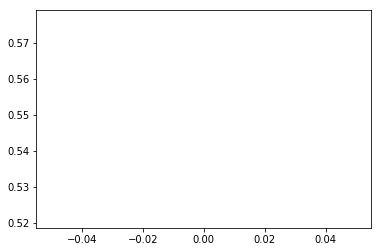

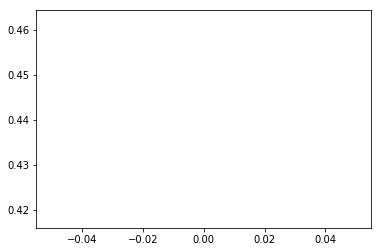

S(i)
0.988445 0.011555
¬S(j)
0.769194 0.230806
¬S(l)
0.123239 0.876761
F(i, j)
0.999785 0.0002145
F(i, m)
0.993702 0.00629808
F(k, l)
0.644376 0.355624
F(m, n)
0.987018 0.0129816
¬F(i, l)
0.0133018 0.986698
¬F(j, m)
0.161299 0.838701
¬F(l, n)
0.999629 0.000370741
¬F(l, m)
1.0 0.0
S(a)
0.934985 0.0650152
S(e)
0.919937 0.0800627
S(f)
0.999724 0.000275875
S(g)
0.0135491 0.986451
¬S(d)
0.997347 0.00265324
F(a, b)
0.0520901 0.94791
F(a, e)
0.284325 0.715675
F(a, g)
0.370691 0.629309
F(e, f)
0.998736 0.00126434
F(g, h)
0.0397776 0.960222
¬F(a, c)
0.0139196 0.98608
¬F(b, d)
0.99999 1.00136e-05
¬F(b, e)
0.69851 0.30149
¬F(b, f)
0.996101 0.00389886
¬F(b, g)
0.999979 2.13385e-05


  0%|          | 1/2000 [00:01<52:29,  1.58s/it]

¬F(b, h)
0.991098 0.00890231
¬F(c, f)
0.984843 0.0151569
¬F(d, g)
0.999899 0.000100732
¬F(f, g)
0.0175093 0.982491
¬F(f, h)
0.877192 0.122808
C(a)
0.445227 0.554773
C(e)
0.853861 0.146139
¬C(b)
0.188281 0.811719
¬C(d)
0.999751 0.000249326
¬C(f)
0.999998 1.66893e-06
¬C(h)
0.999936 6.4373e-05
37


  5%|▌         | 100/2000 [01:12<22:56,  1.38it/s]

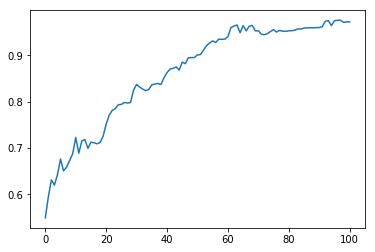

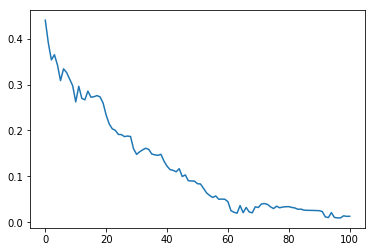

  5%|▌         | 101/2000 [01:13<23:05,  1.37it/s]

S(e)
0.515298 0.484702
F(e, f)
0.0207701 0.97923
¬C(d)
0.234211 0.765789
3


 10%|█         | 200/2000 [02:32<22:55,  1.31it/s]

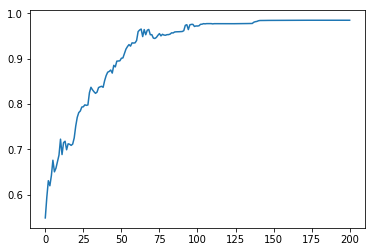

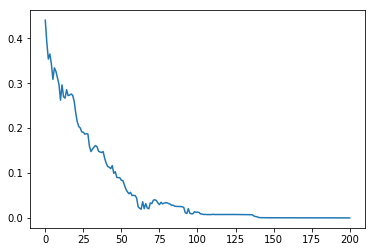

 10%|█         | 201/2000 [02:34<23:00,  1.30it/s]

0


 11%|█         | 220/2000 [02:47<22:34,  1.31it/s]

KeyboardInterrupt: 

In [24]:
ltn1=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]])
kb_train=kb1.union(kb2)
optimizor=torch.optim.Adam(ltn1.parameters(),lr=0.1,weight_decay=0.1)
mone=torch.FloatTensor([-1])
one=torch.FloatTensor([1])
average_prob=[]
averate_loss=[]
for i in tqdm(range(2000)):
    optimizor.zero_grad()
    total_probability=0.0
    total_loss=0.0
    for clause in kb_train.clauses:
        loss,prob=ltn1.forward(clause=clause)
        loss.backward(one)
        total_probability+=prob.data.numpy()[0]
        total_loss+=loss.data.numpy()[0]
    optimizor.step()
    average_prob.append(total_probability/len(kb_train.clauses))
    averate_loss.append(total_loss/len(kb_train.clauses))
    
    if i%100==0:
        plt.plot(average_prob)
        plt.show()
        plt.plot(averate_loss)
        plt.show()
        show_results(ltn1, kb_train)

In [25]:
c=Clause(1,1,[Predicate('F',['c','b'],False)])
print(ltn1.forward(c))
print(c.show())

(Variable containing:
1.00000e-02 *
  7.9611
[torch.FloatTensor of size 1]
, Variable containing:
 0.9204
[torch.FloatTensor of size 1]
)
F(c, b)



  0%|          | 0/2000 [00:00<?, ?it/s]

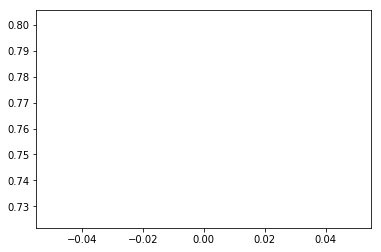

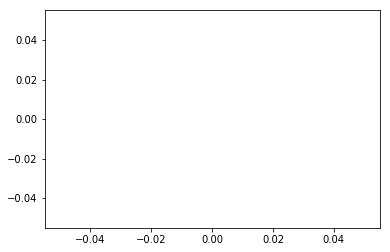

¬S(i) ∨ C(i)
0.999967 3.28403e-05
¬S(i) ∨ ¬F(i, j) ∨ S(j)
0.999586 0.000414431
¬S(i) ∨ ¬F(i, l) ∨ S(l)
0.997065 0.00293487
¬S(k) ∨ ¬F(k, j) ∨ S(j)
0.562536 0.437464
¬S(k) ∨ ¬F(k, l) ∨ S(l)
0.730473 0.269527
¬S(k) ∨ ¬F(k, m) ∨ S(m)
0.200082 0.799918
¬S(k) ∨ ¬F(k, n) ∨ S(n)
0.730473 0.269527
¬F(i, i) ∨ F(i, i)
0.28875 0.71125
¬F(i, j) ∨ F(j, i)
0.982799 0.0172014
¬F(i, l) ∨ F(l, i)
0.681322 0.318678
¬F(j, k) ∨ F(k, j)
0.437464 0.562536
¬F(j, l) ∨ F(l, j)
0.907557 0.0924428
¬F(j, n) ∨ F(n, j)
0.0436706 0.956329
¬F(k, i) ∨ F(i, k)
0.997872 0.00212765
¬F(k, j) ∨ F(j, k)
0.0297787 0.970221
¬F(k, m) ∨ F(m, k)
0.200082 0.799918
¬F(k, n) ∨ F(n, k)
0.999914 8.58307e-05
¬F(m, i) ∨ F(i, m)
0.982785 0.0172148
¬F(m, k) ∨ F(k, m)
0.516389 0.483611
¬F(m, l) ∨ F(l, m)
0.973237 0.0267631
¬F(m, n) ∨ F(n, m)
0.954235 0.0457647
¬F(n, i) ∨ F(i, n)
0.999784 0.000216067
¬F(n, j) ∨ F(j, n)
0.178497 0.821503
¬F(n, n) ∨ F(n, n)
0.0473002 0.9527
¬F(i, i)
0.28875 0.71125
¬F(l, l)
1.0 3.57628e-07
¬F(m, m)
1.0 0.0
¬


  0%|          | 1/2000 [00:06<3:45:29,  6.77s/it]

0.000144551
F(c, d)
0.998947 0.00105302
F(e, f)
0.253655 0.746345
F(g, h)
1.0 1.47258e-08
¬F(a, c)
0.999978 2.15769e-05
¬F(a, d)
0.999858 0.000142097
¬F(b, d)
0.783331 0.216669
¬F(b, e)
0.999887 0.00011313
¬F(b, f)
0.986685 0.013315
¬F(c, e)
0.940482 0.0595183
¬F(c, g)
0.305189 0.694811
¬F(d, e)
0.516962 0.483038
¬F(d, f)
0.127914 0.872086
¬F(d, h)
0.864821 0.135179
¬F(e, g)
0.965782 0.0342185
¬F(f, g)
0.844696 0.155304
C(a)
0.999963 3.74586e-05
¬C(b)
0.990892 0.00910848
¬C(c)
0.0228243 0.977176
¬C(f)
0.999994 5.72205e-06
¬C(g)
1.0 2.38419e-07
¬C(h)
0.999702 0.000298202
117



Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  4%|▍         | 76/2000 [05:57<2:30:39,  4.70s/it]

In [ ]:
kb_train=kb1.union(kb2).union(gkb1).union(gkb2)
ltn2=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]])
optimizor=torch.optim.Adam(ltn2.parameters(),lr=0.1,weight_decay=0.1)
mone=torch.FloatTensor([-1])
one=torch.FloatTensor([1])
average_prob=[]
average_loss=[]
for i in tqdm(range(2000)):
    optimizor.zero_grad()
    total_probability=0.0
    total_loss=0.0
    for clause in kb_train.clauses:
        loss,prob=ltn2.forward(clause=clause)
        loss.backward(one)
        total_probability+=prob.data.numpy()[0]
        total_loss+=loss.data.numpy()[0]
    optimizor.step()
    average_prob.append(total_probability/len(kb_train.clauses))
    average_loss.append(total_loss/len(kb_train.clauses))
    if i%100==0:
        plt.plot(average_prob)
        plt.show()
        plt.plot(averate_loss)
        plt.show()
        show_results(ltn2,kb_train)

In [21]:
show_results(ltn2,kb1)

S(a)
0.999971 2.89519e-05
S(e)
0.147613 0.852387
S(f)
0.999794 0.000206059
S(g)
0.999794 0.000206492
F(b, c)
0.999995 4.89541e-06
F(c, d)
0.999995 5.00549e-06
F(e, f)
0.999994 5.82879e-06
F(g, h)
0.999995 4.9862e-06
¬F(a, c)
0.999897 0.000103474
¬F(a, d)
0.999893 0.000106812
¬F(a, h)
0.999878 0.000121951
11
